In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import logging
import os
import random
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import networkx as nx
from pyvis.network import Network
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from model import KGEModel
from dataloader import TrainDataset, BidirectionalOneShotIterator
from visualisation_pyvis import data_prep

#### Above are the importations of the neccessary libraries needed for this work. 

#### below, we defined all the parameters needed in this pipeline

In [2]:
class Args:
    def __init__(self):
        self.cuda = False
        self.do_train = True
        self.do_valid = True
        self.do_test = True
        self.evaluate_train = False
        self.countries = False
        self.regions = None
        self.data_path = 'data/organized'
        self.model = 'TransE'
        self.double_entity_embedding = False
        self.double_relation_embedding = False
        self.negative_sample_size = 128
        self.hidden_dim = 200
        self.gamma = 12.0
        self.negative_adversarial_sampling = False
        self.adversarial_temperature = 1.0
        self.batch_size = 1024
        self.regularization = 0.0
        self.test_batch_size = 4
        self.uni_weight = False
        self.learning_rate = 0.0001
        self.cpu_num = 8
        self.init_checkpoint = None
        self.save_path = 'models/TransE'
        self.max_steps = 100
        self.warm_up_steps = None
        self.save_checkpoint_steps = 1000
        self.valid_steps = 20
        self.log_steps = 20
        self.test_log_steps = 20
        self.nentity = 0
        self.nrelation = 0
        self.entities = 'entities.dict'
        self.relations = 'relations.dict'

args = Args()

#### Passing the data and displaying and exemple of what the database looks like. A general database contain

In [3]:
edge_data = pd.read_csv("data/hetionet-v1.0-edges.sif", sep = "\t")
node_data = pd.read_csv("data/hetionet-v1.0-nodes.tsv", sep = "\t")
meta_edge_data = pd.read_csv("data/metaedges.tsv", sep = "\t")
print(edge_data.head(5))
print(node_data.head(5))
print(meta_edge_data.head(5))

        source metaedge                          target
0   Gene::9021     GpBP  Biological Process::GO:0071357
1  Gene::51676     GpBP  Biological Process::GO:0098780
2     Gene::19     GpBP  Biological Process::GO:0055088
3   Gene::3176     GpBP  Biological Process::GO:0010243
4   Gene::3039     GpBP  Biological Process::GO:0006898
                        id                       name     kind
0  Anatomy::UBERON:0000002             uterine cervix  Anatomy
1  Anatomy::UBERON:0000004                       nose  Anatomy
2  Anatomy::UBERON:0000006        islet of Langerhans  Anatomy
3  Anatomy::UBERON:0000007            pituitary gland  Anatomy
4  Anatomy::UBERON:0000010  peripheral nervous system  Anatomy
                          metaedge abbreviation   edges  source_nodes  \
0   Anatomy - downregulates - Gene          AdG  102240            36   
1       Anatomy - expresses - Gene          AeG  526407           241   
2     Anatomy - upregulates - Gene          AuG   97848            

#### We proceed with creating a dictionary of all the entities (head and tail) and relations as well.

In [4]:
def create_entity_relation_dicts_from_df(data_path, triples_df):
    entity_set = set(triples_df['source']).union(set(triples_df['target']))
    relation_set = set(triples_df['metaedge'])

    entity2id = {entity: idx for idx, entity in enumerate(entity_set)}
    relation2id = {relation: idx for idx, relation in enumerate(relation_set)}

    with open(os.path.join(data_path, args.entities), 'w') as fout:
        for entity, idx in entity2id.items():
            fout.write(f"{idx}\t{entity}\n")

    with open(os.path.join(data_path, args.relations), 'w') as fout:
        for relation, idx in relation2id.items():
            fout.write(f"{idx}\t{relation}\n")

    return entity2id, relation2id

#triples_df = pd.read_csv("data/FB15k/hetionet-v1.0-edges.sif", delimiter="\t")
entity2id, relation2id = create_entity_relation_dicts_from_df(args.data_path, edge_data)

#### We devide the node-relation dataset into train, test, validation and saved them in a text file. training large dataset is computationaly expensive, while constructing this pipeline, We used a minimal of less than 10% of the entire data to quickly iterate over data and resolve errors. at the end, we will use the entire data.

In [12]:
# Split the dataset into train, validation, and test sets
d1, d2 = train_test_split(edge_data, test_size=0.95, random_state=42)
d11, d22 = train_test_split(d1, test_size=0.95, random_state=42)

train_data, test_data = train_test_split(d11, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# output dataframe to text file
def save_to_text_file(df, file_name):
    df.to_csv(file_name, sep='\t', index=False, header = False)

# Save train, validation, and test datasets to text files
save_to_text_file(train_data, os.path.join(args.data_path, 'train.txt'))
save_to_text_file(val_data, os.path.join(args.data_path, 'valid.txt'))
save_to_text_file(test_data, os.path.join(args.data_path, 'test.txt'))

#### We use pyvis to provide an overview visualisatio of the our dataset. below is the entity-relations representations. From left to right train, valid and test.

In [12]:
split_data = [train_data, val_data, test_data]
data_names = ["train", "test", "valid"]

entity2id, relation2id = data_prep.triples(args.entities, args.relations, args.data_path)

for i, _ in enumerate(split_data):
    title = f"{data_names[i]} data representation"
    triples = data_prep.read_triple(os.path.join(args.data_path, f"{data_names[i]}.txt"), entity2id, relation2id)
    data_prep.data_viz(triples, title)

train data representation.html
test data representation.html
valid data representation.html


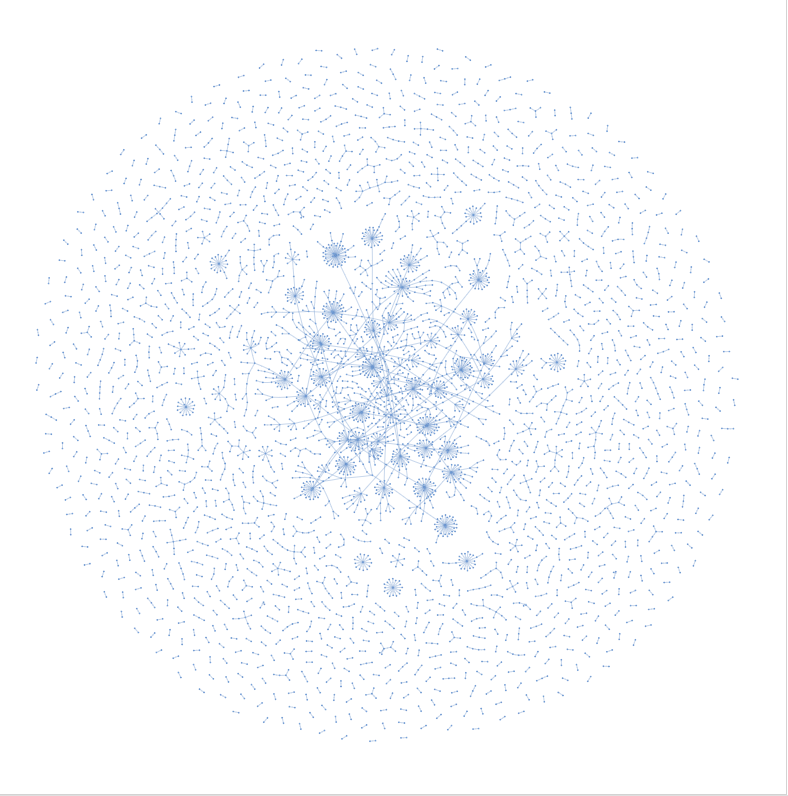 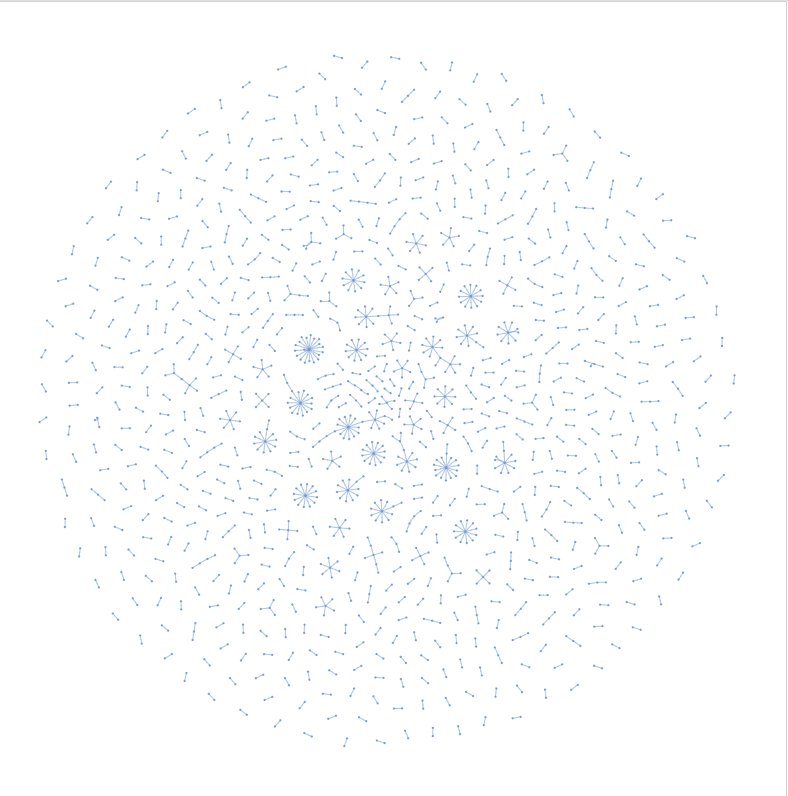 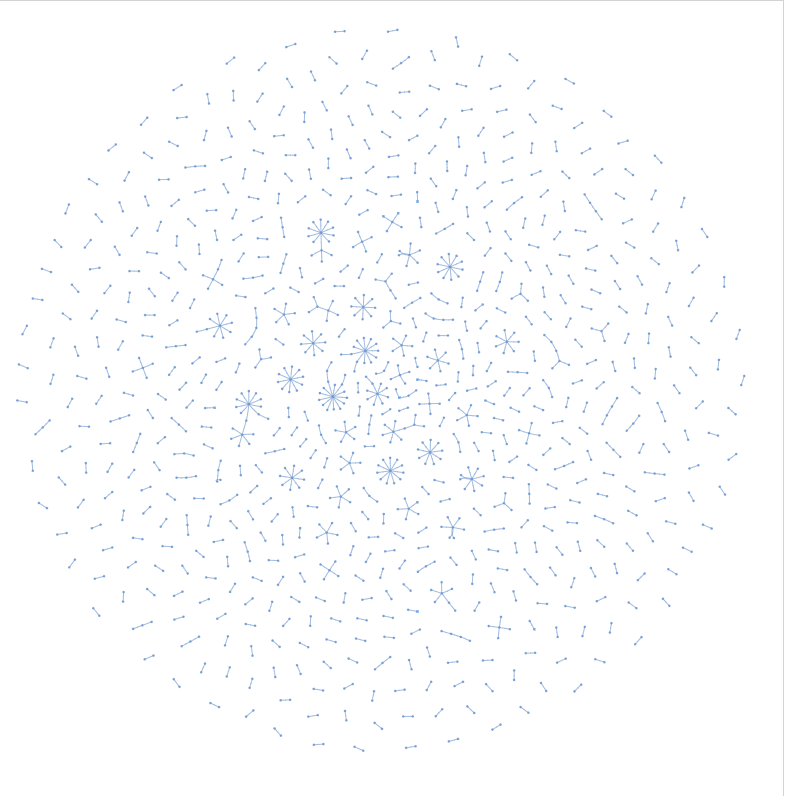 

#### Define the function to be used for display, tracking the execution state along the trainng and validation

In [102]:
def set_logger(args):
    log_file = os.path.join(args.save_path or args.init_checkpoint, 'train.log')
    logging.basicConfig(
        format='%(asctime)s %(message)s',
        level=logging.INFO,
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )

def log_metrics(mode, step, metrics):
    for metric in metrics:
        logging.info('%s %s at step %d: %f' % (mode, metric, step, metrics[metric]))

#### The main code containg... each part will be described in detail

In [20]:
def override_config(args):
    # Implement the logic to override config based on checkpoint
    pass

def save_model(model, optimizer, save_variable_list, args):
    # Implement the logic to save the model
    pass
def main(args):
    if (not args.do_train) and (not args.do_valid) and (not args.do_test):
        raise ValueError('One of train/val/test mode must be chosen.')
    
    if args.init_checkpoint:
        override_config(args)
    elif args.data_path is None:
        raise ValueError('One of init_checkpoint/data_path must be chosen.')

    if args.do_train and args.save_path is None:
        raise ValueError('Where do you want to save your trained model?')
    
    if args.save_path and not os.path.exists(args.save_path):
        os.makedirs(args.save_path)
    
    set_logger(args)
    
    entity2id, relation2id = data_prep.triples(entities, relations, args.data_path)
   
    nentity = len(entity2id)
    nrelation = len(relation2id)
    
    args.nentity = nentity
    args.nrelation = nrelation
    
    logging.info('Model: %s' % args.model)
    logging.info('Data Path: %s' % args.data_path)
    logging.info('#entity: %d' % nentity)
    logging.info('#relation: %d' % nrelation)
    
    train_triples = data_prep.read_triple(os.path.join(args.data_path, 'train.txt'), entity2id, relation2id)
    logging.info('#train: %d' % len(train_triples))
    valid_triples = data_prep.read_triple(os.path.join(args.data_path, 'valid.txt'), entity2id, relation2id)
    logging.info('#valid: %d' % len(valid_triples))
    test_triples = data_prep.read_triple(os.path.join(args.data_path, 'test.txt'), entity2id, relation2id)
    logging.info('#test: %d' % len(test_triples))
    
    all_true_triples = train_triples + valid_triples + test_triples
    
    kge_model = KGEModel(
        model_name=args.model,
        nentity=nentity,
        nrelation=nrelation,
        hidden_dim=args.hidden_dim,
        gamma=args.gamma,
        double_entity_embedding=args.double_entity_embedding,
        double_relation_embedding=args.double_relation_embedding
    )
    
    logging.info('Model Parameter Configuration:')
    for name, param in kge_model.named_parameters():
        logging.info('Parameter %s: %s, require_grad = %s' % (name, str(param.size()), str(param.requires_grad)))

    if args.cuda:
        kge_model = kge_model.cuda()
    
    if args.do_train:
        train_dataloader_head = DataLoader(
            TrainDataset(train_triples, nentity, nrelation, args.negative_sample_size, 'head-batch'), 
            batch_size=args.batch_size*2,
            shuffle=True, 
            num_workers=max(1, args.cpu_num//2),
            collate_fn=TrainDataset.collate_fn
        )
        
        train_dataloader_tail = DataLoader(
            TrainDataset(train_triples, nentity, nrelation, args.negative_sample_size, 'tail-batch'), 
            batch_size=args.batch_size*2,
            shuffle=True, 
            num_workers=max(1, args.cpu_num//2),
            collate_fn=TrainDataset.collate_fn
        )
        
        train_iterator = BidirectionalOneShotIterator(train_dataloader_head, train_dataloader_tail)
        
        current_learning_rate = args.learning_rate
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, kge_model.parameters()), 
            lr=current_learning_rate
        )
        if args.warm_up_steps:
            warm_up_steps = args.warm_up_steps
        else:
            warm_up_steps = args.max_steps // 2

    if args.init_checkpoint:
        logging.info('Loading checkpoint %s...' % args.init_checkpoint)
        checkpoint = torch.load(os.path.join(args.init_checkpoint, 'checkpoint'))
        init_step = checkpoint['step']
        kge_model.load_state_dict(checkpoint['model_state_dict'])
        if args.do_train:
            current_learning_rate = checkpoint['current_learning_rate']
            warm_up_steps = checkpoint['warm_up_steps']
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        logging.info('Randomly Initializing %s Model...' % args.model)
        init_step = 0

    #Training loop
    step = init_step
    #logging initial parameters
    logging.info('Start Training...')
    logging.info('init_step = %d' % init_step)
    logging.info('batch_size = %d' % args.batch_size)
    logging.info('negative_adversarial_sampling = %d' % args.negative_adversarial_sampling)
    logging.info('hidden_dim = %d' % args.hidden_dim)
    logging.info('gamma = %f' % args.gamma)
    logging.info('negative_adversarial_sampling = %s' % str(args.negative_adversarial_sampling))
    if args.negative_adversarial_sampling:
        logging.info('adversarial_temperature = %f' % args.adversarial_temperature)

    #Checking training condition
    if args.do_train:
        logging.info('learning_rate = %d' % current_learning_rate)

        training_logs = []

        #training loop initialise from initial stem to maximum step
        for step in range(init_step, args.max_steps):
            #Trianing step: calls the training model in a single step and return the log metrics
            log = kge_model.train_step(kge_model, optimizer, train_iterator, args)
            
            training_logs.append(log)
            
            #learning rate adjustment
           # if step >= warm_up_steps: #warm up steps should always be lower
           #     current_learning_rate = current_learning_rate / 10
           #     logging.info('Change learning_rate to %f at step %d' % (current_learning_rate, step))
           #     #creates a new adam optimizer with the new leatning rate
           #     optimizer = torch.optim.Adam(
           #         filter(lambda p: p.requires_grad, kge_model.parameters()), 
           #         lr=current_learning_rate
           #     )
           #     warm_up_steps = warm_up_steps * 3
            #save checkpoints
            if step % args.save_checkpoint_steps == 0:
                save_variable_list = {
                    'step': step, 
                    'current_learning_rate': current_learning_rate,
                    'warm_up_steps': warm_up_steps
                }
                save_model(kge_model, optimizer, save_variable_list, args)
                
            if step % args.log_steps == 0:
                metrics = {}
                for metric in training_logs[0].keys():
                    metrics[metric] = sum([log[metric] for log in training_logs])/len(training_logs)
                log_metrics('Training average', step, metrics)
                training_logs = []
                
            if args.do_valid and step % args.valid_steps == 0:
                logging.info('Evaluating on Valid Dataset...')
                metrics = kge_model.test_step(kge_model, valid_triples, all_true_triples, args)
                log_metrics('Valid', step, metrics)
        
        save_variable_list = {
            'step': step, 
            'current_learning_rate': current_learning_rate,
            'warm_up_steps': warm_up_steps
        }
        save_model(kge_model, optimizer, save_variable_list, args)
        
    if args.do_valid:
        logging.info('Evaluating on Valid Dataset...')
        metrics = kge_model.test_step(kge_model, valid_triples, all_true_triples, args)
        log_metrics('Valid', step, metrics)
    
    if args.do_test:
        logging.info('Evaluating on Test Dataset...')
        metrics = kge_model.test_step(kge_model, test_triples, all_true_triples, args)
        log_metrics('Test', step, metrics)
    
    if args.evaluate_train:
        logging.info('Evaluating on Training Dataset...')
        metrics = kge_model.test_step(kge_model, train_triples, all_true_triples, args)
        log_metrics('Test', step, metrics)

    entity_embeddings = kge_model.entity_embedding.detach().cpu().numpy()
    relation_embeddings = kge_model.relation_embedding.detach().cpu().numpy()
    return entity_embeddings, relation_embeddings

# Initialize the argument class
args = Args()

# Run the main function with these arguments
entity_embeddings, relation_embeddings = main(args)

2024-07-29 14:58:22,401 Model: TransE
2024-07-29 14:58:22,402 Data Path: data/FB15k
2024-07-29 14:58:22,402 #entity: 45158
2024-07-29 14:58:22,403 #relation: 24
2024-07-29 14:58:22,411 #train: 3600
2024-07-29 14:58:22,419 #valid: 900
2024-07-29 14:58:22,423 #test: 1125
2024-07-29 14:58:22,612 Model Parameter Configuration:
2024-07-29 14:58:22,612 Parameter gamma: torch.Size([1]), require_grad = False
2024-07-29 14:58:22,613 Parameter embedding_range: torch.Size([1]), require_grad = False
2024-07-29 14:58:22,614 Parameter entity_embedding: torch.Size([45158, 200]), require_grad = True
2024-07-29 14:58:22,615 Parameter relation_embedding: torch.Size([24, 200]), require_grad = True
2024-07-29 14:58:22,650 Randomly Initializing TransE Model...
2024-07-29 14:58:22,651 Start Training...
2024-07-29 14:58:22,651 init_step = 0
2024-07-29 14:58:22,651 batch_size = 1024
2024-07-29 14:58:22,652 negative_adversarial_sampling = 0
2024-07-29 14:58:22,653 hidden_dim = 200
2024-07-29 14:58:22,654 gamma

#### using pca and t-sne to present\visualize the embeddings state

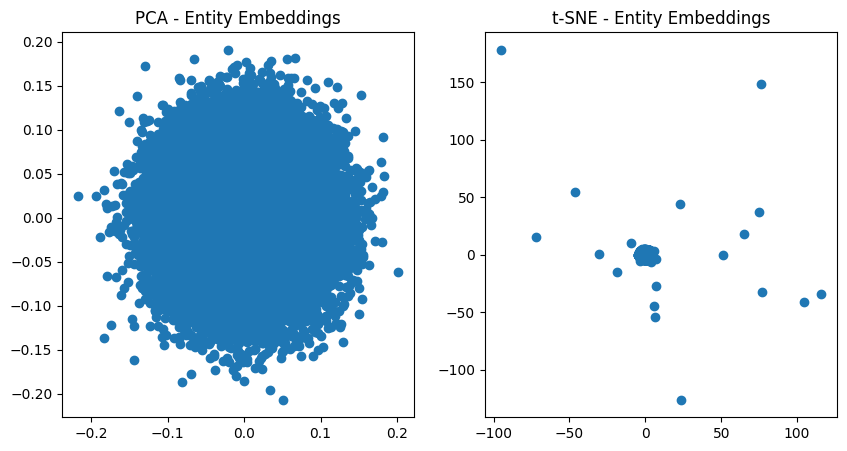

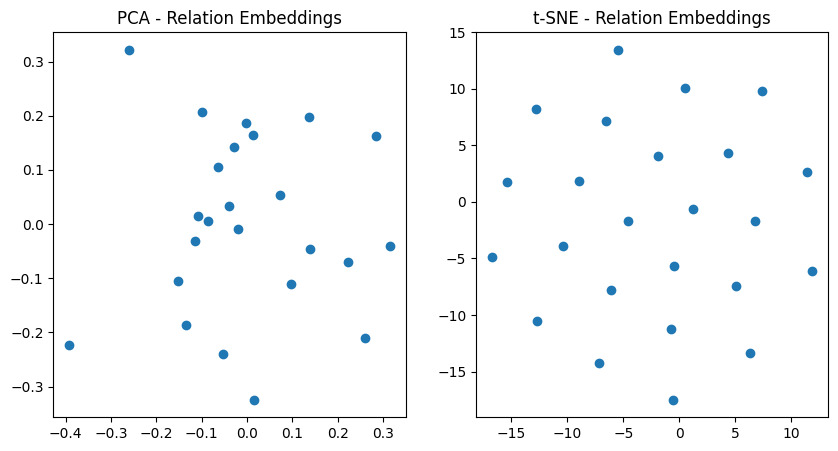

In [22]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming entity_embedding and relation_embedding are numpy arrays
def visualize_embeddings(embeddings, title):
    pca = PCA(n_components=2)
    
    # Adjust the perplexity based on the number of samples
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)
    
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=300)
    
    pca_result = pca.fit_transform(embeddings)
    tsne_result = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(pca_result[:, 0], pca_result[:, 1])
    plt.title(f'PCA - {title}')

    plt.subplot(1, 2, 2)
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
    plt.title(f't-SNE - {title}')

    plt.show()

# Visualize embeddings
visualize_embeddings(entity_embeddings, 'Entity Embeddings')
visualize_embeddings(relation_embeddings, 'Relation Embeddings')

#### ...

In [73]:
from pyvis.network import Network
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
embeddings = []
# Function to visualize embeddings with pyvis
def visualize_embeddings_with_pyvis(embeddings, title):
    pca = PCA(n_components=2)
    
    # Adjust the perplexity based on the number of samples
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)
    
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300)

    pca_result = pca.fit_transform(embeddings)
    tsne_result = tsne.fit_transform(embeddings)

    # Convert embeddings to a JSON-serializable format
    pca_result = pca_result.astype(float).tolist()
    tsne_result = tsne_result.astype(float).tolist()
    return embeddings, pca_result, tsne_result

embeddings, pca_result, tsne_result = visualize_embeddings_with_pyvis(entity_embeddings, 'Entity Embeddings')

/home/akabetso/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [85]:
# Create Pyvis networks for PCA and t-SNE
def create_pyvis_network(embeddings, labels, title):
    net = Network(notebook=True)
    nx_graph = nx.Graph()
    
    # Add nodes
    for i, (x, y) in enumerate(embeddings):
        nx_graph.add_node(i, x=x, y=y, label=labels[i], title=labels[i])
    
    # Convert nx graph to pyvis
    net.from_nx(nx_graph)
    net.show_buttons(filter_=['physics'])
    net.show(f"{title}.html", notebook = False)

# Labels for your entities (for demonstration purposes)
labels = [f'title {i}' for i in range(len(embeddings))]

# Create networks for PCA and t-SNE embeddings
create_pyvis_network(pca_result, labels, f'PCA title')
create_pyvis_network(tsne_result, labels, f't-SNE title')


PCA title.html
t-SNE title.html


In [144]:
def create_pyvis_network(embeddings, labels, title, triples):
    nx_graph = nx.Graph()

    # Add nodes
    for i, (x, y) in enumerate(embeddings):
        nx_graph.add_node(i, x=x, y=y, label=labels[i], title=labels[i])

    # Add edges based on triples
    for head, relation, tail in triples:
        nx_graph.add_edge(head, tail, title=f'Relation {relation}', value=1)

    net = Network('800px', '800px', notebook=True)
    net.from_nx(nx_graph)
    net.show_buttons(filter_=['physics'])
    net.show(f"{title}.html", notebook=False)

title = "Entity_embeddings"
labels = [f'Entity_embeddings {i}' for i in range(embeddings.shape[0])]
# Create networks for PCA and t-SNE embeddings
create_pyvis_network(pca_result, labels, f'PCA {title}', valid_triples)
# Example entity embeddings
#entity_embeddings = torch.rand(100, 64).numpy()  # Convert to numpy array
#entity_labels = [entity for entity, _ in sorted(entity2id.items(), key=lambda item: item[1])]
# Visualize embeddings with edges
#visualize_embeddings_with_pyvis(entity_embeddings, entity_labels, 'Entity Embeddings', train_triples)


PCA Entity_embeddings.html


In [ ]:
#### to be continued..................................
from sklearn.cluster import KMeans

def cluster_entities(embeddings, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(embeddings)
    return clusters

entity_clusters = cluster_entities(entity_embedding)
plt.scatter(entity_embedding[:, 0], entity_embedding[:, 1], c=entity_clusters)
plt.title('Entity Clusters')
plt.show()

In [88]:
def predict_links(model, head, relation, top_k=10):
    # Assuming model has a method predict that returns scores for all possible tails
    scores = model.predict(head, relation)
    top_k_indices = scores.argsort()[-top_k:][::-1]
    return top_k_indices

# Example: Predict top 10 entities for a given head and relation
head = ...  # Entity ID
relation = ...  # Relation ID
top_entities = predict_links(kmodel, head, relation)
print(f'Top {top_k} entities for (head={head}, relation={relation}): {top_entities}')


NameError: name 'kge_model' is not defined